$f(x,y) = - \left(\dfrac{3}{(x^2+ 8)} + \dfrac{5}{(y^2+ 8)}\right)$


#Двуслойная нейросеть. Вариант 29 (PReLU,Гиперболический тангенс,SGD) Едленко 4к. 6г.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import math
import pickle
import os.path

from keras.utils import to_categorical
from keras import models
from keras import layers

In [ ]:
def prelu(x, alpha):
    return np.where( x < 0, alpha * x, x)

def prelu_diff(x, alpha):
    return np.where(x < 0, np.ones(x.shape) * alpha, np.ones(x.shape))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_diff(y):
    return y*(1 - y)

def tanh(x):
    return 2 * sigmoid(2*x) - 1

def tanh_diff(x):
    return 1 - tanh(x)**2



In [ ]:
from numpy.lib import math
class NeuralNetwork_two:
    def __init__(self, x, y): #  объём датасета
        self.input       = x 
        self.y           = y 
        self.diam_1      = 18
        self.diam_2      = 10
        self.weights1    = np.random.rand(self.diam_1, self.input.shape[0]) 
        self.weights2    = np.random.rand(self.diam_2, self.diam_1) 
        self.weights3    = np.random.rand(1, self.diam_2) # 
        self.output      = np.zeros(self.y.shape) 
        self.alpha       = 0.001
        self.bias_1      = np.random.rand(self.diam_1, 1)
        self.bias_2      = np.random.rand(self.diam_2, 1)
        self.b           = np.random.rand()
        self.prelu_alpha = 0.1

        self.shuff      = np.arange(self.input.shape[1])
        np.random.shuffle(self.shuff)
        
    def feedforward(self):
      self.layer1 = prelu(np.dot(self.weights1, self.input) + self.bias_1, self.alpha) 
      self.layer2 = tanh(np.dot(self.weights2, self.layer1) + self.bias_2) 
      self.output = np.dot(self.weights3, self.layer2) + self.b
        
    def backprop(self):

        d_weights3 = 2*np.dot((self.y - self.output),self.layer2.T) 
        d_weights2 = 2*self.weights3.T*np.dot((self.y - self.output)*prelu_diff(self.layer2, self.prelu_alpha),self.layer1.T )
        d_weights1 = 2*np.dot(np.dot(self.weights3*self.weights2.T,(self.y - self.output)*prelu_diff(self.layer2, self.prelu_alpha))*prelu_diff(self.layer1, self.prelu_alpha),self.input.T)
        d_bias_2   = 2*self.weights3.T*np.dot(prelu_diff(self.layer2, self.alpha), (self.y - self.output).T)
        d_bias_1   = 2*np.dot(np.dot(self.weights3*self.weights2.T,prelu_diff(self.layer2, self.prelu_alpha))*prelu_diff(self.layer1, self.prelu_alpha), (self.y - self.output).T)
        d_b        = 2*(self.y - self.output).sum()


        self.weights1 += self.alpha * d_weights1/self.input.shape[1]
        self.weights2 += self.alpha * d_weights2/self.input.shape[1]
        self.weights3 += self.alpha * d_weights3/self.input.shape[1]
        self.bias_1   += self.alpha * d_bias_1/self.input.shape[1]
        self.bias_2   += self.alpha * d_bias_2/self.input.shape[1]
        self.b        += self.alpha * d_b/self.input.shape[1]

    def test(self, t):
      sizeX = int(math.sqrt(t.shape[1])) #Размерность матрицы по X и Y
      return (np.dot(self.weights3, tanh(np.dot(self.weights2, prelu(np.dot(self.weights1, t) + self.bias_1, self.alpha)) + self.bias_2)) + self.b)


In [ ]:
def avgErr(y_true, y_pred):
      return ((y_true - y_pred) ** 2).mean()

In [ ]:
def func(x,y):
    return -((3 / (x*x + 8)) + (5 / (y*y + 8)))

In [ ]:
dim_x = 100
X = np.arange(-20, 20, 1)
Y = np.arange(-20, 20, 1)
X, Y = np.meshgrid(X, Y)
X1, Y1 = X.ravel(), Y.ravel()
dataset = np.array([X1, Y1])
Z1 = func(X1, Y1)
Z1_dataset = np.array([list(Z1)])

dataset = np.array([X1, Y1])


In [ ]:
Xd = np.array([X1,Y1])
Xd.shape

(2, 1600)

In [ ]:
Zd = np.array([list(Z1)])
Zd.shape

(1, 1600)

In [ ]:
BATCH_COUNT = 10

shuffle_indexes_dataset = np.arange(dataset.shape[1])
np.random.shuffle(shuffle_indexes_dataset)
size_batch = int(dataset.shape[1] / BATCH_COUNT) #Размер одного батча
ostatok = dataset.shape[1] % BATCH_COUNT         #Для кусочка в последнем батче
for i in np.arange(BATCH_COUNT):
  if (i != BATCH_COUNT - 1):
   batch_indexes = shuffle_indexes_dataset[i*size_batch : (i+1)*size_batch]
  else:
   batch_indexes = shuffle_indexes_dataset[i*size_batch : (i+1)*size_batch + ostatok]
  batch_data = dataset[:,batch_indexes]
  batch_Z = Z1_dataset[:,batch_indexes]
  z = NeuralNetwork_two(batch_data, batch_Z)

In [ ]:
# z = NeuralNetwork_two(Xd,Zd)

# print(z.test(Xd))
# print(Z1)

z.alpha = 0.001
avg_pred = 0


In [ ]:
for i in range(200000):
    z.feedforward()
    z.backprop()
 
    if i % 1000 == 0:
      avg = avgErr(Zd, z.test(Xd))
      if (np.absolute(avg_pred - avg) < 0.001) and z.alpha > 0.00001:
        z.alpha /= 2    
      avg_pred = avg
      print('avg:', avg)
    if avg < 0.0001:
      break



avg: 31.98008596990029
avg: 0.05611850770080734
avg: 0.05455562078356634
avg: 0.018868732048781225
avg: 0.015251696752719573
avg: 0.013411746317829423
avg: 0.012095632261409129
avg: 0.0113031194251756
avg: 0.010914788926087247
avg: 0.010802654439524129
avg: 0.010760304014441713
avg: 0.010732614249406143
avg: 0.010718959159300484
avg: 0.01071200156631552
avg: 0.010708517789448027
avg: 0.010706775273134194
avg: 0.010705903388222655
avg: 0.010705188580562035
avg: 0.010704472653778014
avg: 0.010703755686021872
avg: 0.010703037456764278
avg: 0.010702318354100647
avg: 0.010701599815329619
avg: 0.010700881362168317
avg: 0.010700161677960493
avg: 0.010699441741724419
avg: 0.010698721737326142
avg: 0.010698000461882202
avg: 0.010697278541790901
avg: 0.010696555536767944
avg: 0.010695831454681795
avg: 0.010695106745530116
avg: 0.010694381107146012
avg: 0.010693654647930475
avg: 0.010692927192268198
avg: 0.010692198697452662
avg: 0.010691469510292253
avg: 0.010690739436158421
avg: 0.0106900113869

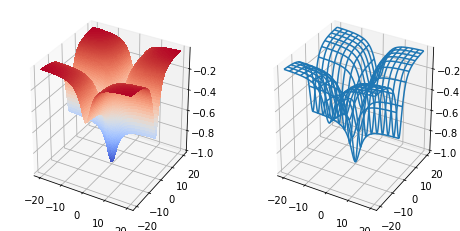

In [ ]:
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
X = np.arange(-20, 20, 0.25)
Y = np.arange(-20, 20, 0.25)
X, Y = np.meshgrid(X, Y)
Z = func(X, Y)
#X, Y, Z = get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)


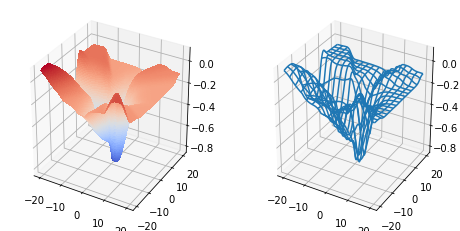

In [ ]:
fig_2 = plt.figure(figsize=plt.figaspect(0.5))

ax_2 = fig_2.add_subplot(1, 2, 1, projection='3d')
X = np.arange(-20, 20.25, 0.25)
Y = np.arange(-20, 20.25, 0.25)
X, Y = np.meshgrid(X, Y)

Z = z.test(np.array([X.ravel(),Y.ravel()])).reshape((161,161))

ax_2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax_2 = fig_2.add_subplot(1, 2, 2, projection='3d')

ax_2.plot_wireframe(X, Y, Z, rstride=10, cstride=10)